<a href="https://colab.research.google.com/github/corralem/MITFutureMakers/blob/main/NewSarcasmDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import gensim
from keras.optimizers import Adam
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, ReLU, GlobalMaxPooling1D, Conv1D, LeakyReLU, BatchNormalization, MaxPooling1D, Flatten

# Basic Libraries

import numpy as np
import pandas as pd

#Visuals

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff

#NLP tasks

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer  
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS


#DL Tasks

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,GlobalAvgPool1D,Dense,Dropout,Bidirectional,LSTM,GRU
import tensorflow as tf

#ML Tasks

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBClassifier,XGBRFRegressor,XGBRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from keras.utils.np_utils import to_categorical


import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df1 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df1.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
df2 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df2.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
# Combine both datasets
df = pd.concat([df1, df2], ignore_index=True)
df = df.drop(columns=["article_link"])

df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [10]:
# Check for NaN values
df.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



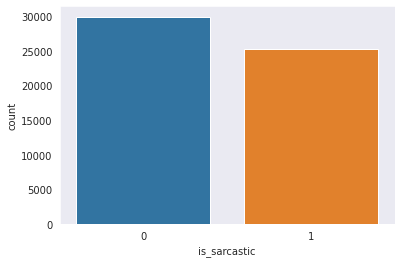

In [11]:
#Visualizing if the data is evenly dispersed 
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [12]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

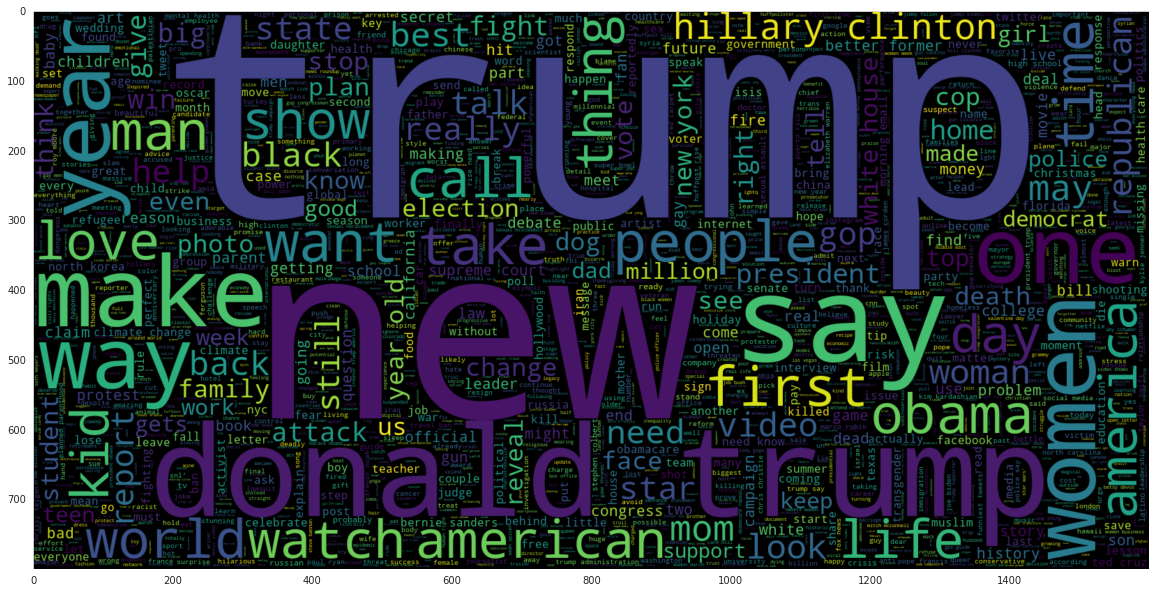

In [15]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

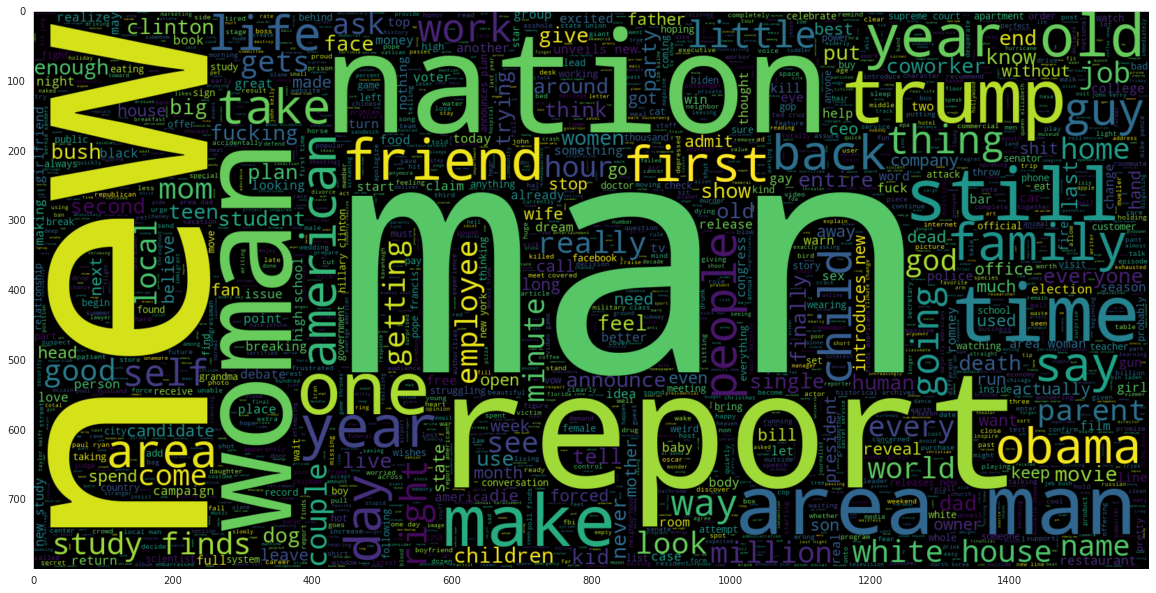

In [16]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

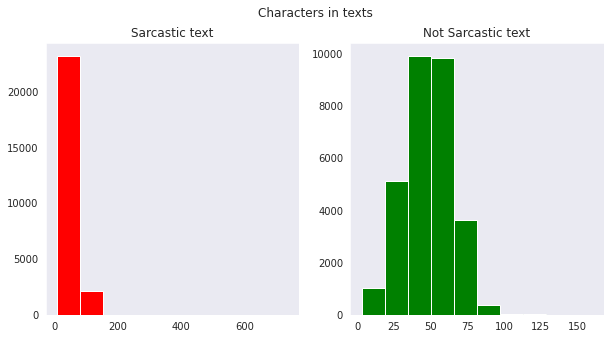

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

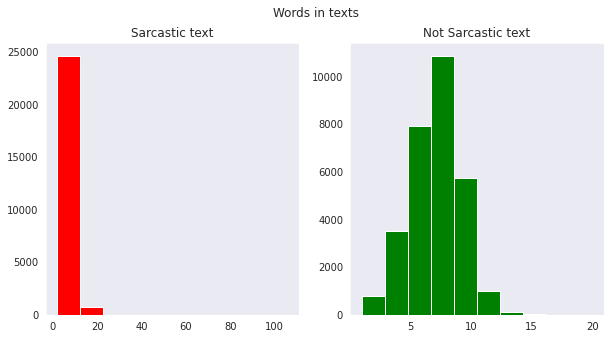

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0.98, 'Average word length in each text')

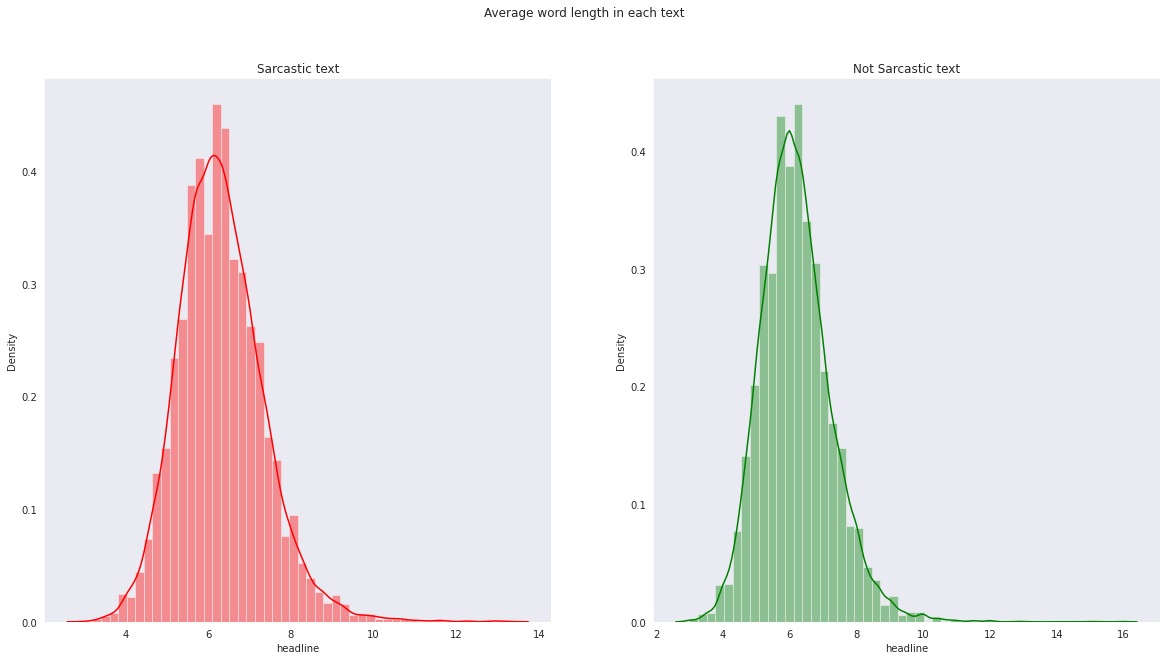

In [19]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [20]:
labels=np.array(df.is_sarcastic)
len(np.unique(labels))

2

In [21]:
tf=Tokenizer(num_words=1000,oov_token="oov<>")
tf.fit_on_texts(df.headline)

In [22]:
a=tf.word_index
a["oov<>"]

1

In [23]:
seq=tf.texts_to_sequences(df.headline)
seq[:5]

[[1, 293, 1, 1, 1, 553, 988],
 [1, 1, 631, 1, 149, 1, 933, 1, 1, 1],
 [735, 1, 167, 1, 527, 1],
 [1, 1, 1, 1, 78, 83],
 [372, 386, 243, 811, 502, 437, 1, 1]]

In [24]:
pad=pad_sequences(seq,maxlen=100,padding="post")

In [25]:
pad=np.array(pad)

In [26]:
pad

array([[  1, 293,   1, ...,   0,   0,   0],
       [  1,   1, 631, ...,   0,   0,   0],
       [735,   1, 167, ...,   0,   0,   0],
       ...,
       [  1,  23,   0, ...,   0,   0,   0],
       [  1, 302,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]], dtype=int32)

In [27]:
num_class=len(np.unique(labels))

In [28]:
xr,xt,yr,yt=train_test_split(pad,labels,test_size=0.1)

In [31]:
from keras.utils.np_utils import to_categorical
yr=to_categorical(yr,num_class)
yt=to_categorical(yt,num_class)

In [32]:
model=Sequential()
model.add(Embedding(10000,10,input_length=100))
model.add(Bidirectional(GRU(32,return_sequences=True)))
model.add(GlobalAvgPool1D())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class,activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 10)           100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           8448      
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 500)               32500     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1002      
Total params: 141,950
Trainable params: 141,950
Non-trainable params: 0
__________________________________________________

In [40]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [42]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [45]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=words , size=EMBEDDING_DIM, window=5, min_count=1)

In [46]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [47]:
tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
X = pad_sequences(tokenized_train, maxlen=20)

In [48]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1


In [50]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [51]:
# Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, df.is_sarcastic, train_size=0.8, random_state=42)

In [57]:
opt = Adam(learning_rate=0.0005)

model = Sequential()

model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(32)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(
  optimizer=opt, 
  loss="binary_crossentropy", 
  metrics=["acc"]
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    shuffle=True
)

Epoch 1/10
294/294 [==============================] - 119s 358ms/step - loss: 0.6270 - acc: 0.6330 - val_loss: 0.3389 - val_acc: 0.8542
Epoch 2/10
294/294 [==============================] - 101s 343ms/step - loss: 0.2362 - acc: 0.9103 - val_loss: 0.2339 - val_acc: 0.9044
Epoch 3/10
294/294 [==============================] - 100s 342ms/step - loss: 0.0928 - acc: 0.9669 - val_loss: 0.2522 - val_acc: 0.9119
Epoch 4/10
294/294 [==============================] - 100s 342ms/step - loss: 0.0475 - acc: 0.9843 - val_loss: 0.2907 - val_acc: 0.9206
Epoch 5/10
294/294 [==============================] - 101s 342ms/step - loss: 0.0311 - acc: 0.9903 - val_loss: 0.3124 - val_acc: 0.9215
Epoch 6/10
294/294 [==============================] - 100s 340ms/step - loss: 0.0200 - acc: 0.9928 - val_loss: 0.3450 - val_acc: 0.9244
Epoch 7/10
294/294 [==============================] - 100s 341ms/step - loss: 0.0164 - acc: 0.9946 - val_loss: 0.3226 - val_acc: 0.9230
Epoch 8/10
294/294 [============================

In [59]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                73984     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)               

In [61]:

model.evaluate(X_test, y_test)

346/346 [==============================] - 11s 32ms/step - loss: 0.4250 - acc: 0.9254


[0.4249752163887024, 0.925356924533844]

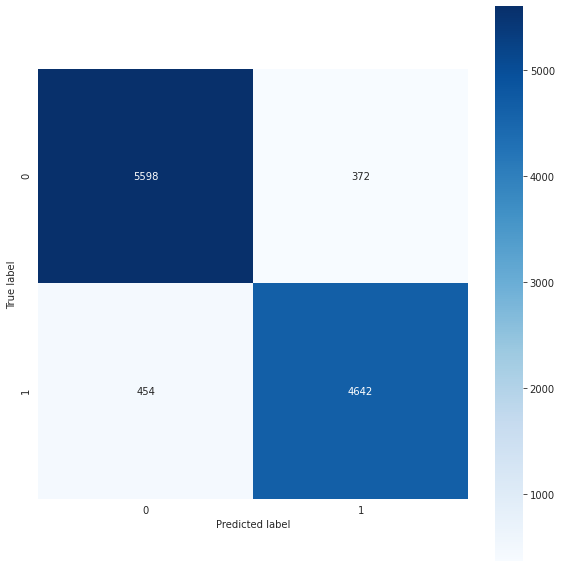

In [62]:

y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, square=True, fmt="")
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()